# Imports & settings

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from pathlib import Path
import warnings
import copy

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.decomposition import PCA
SCALERS = {'minmax' : MinMaxScaler, 'robust': RobustScaler, 'standard': StandardScaler}

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
RAW_DATA_PATH = Path("/home/admin/code/arnaud-odet/7_PhD/Roster/raw_data/muniz_data")
PREPROC_DATA_PATH = Path("/home/admin/code/arnaud-odet/7_PhD/Roster/preproc_data")
PENALTY_RATE = 1
POSITION_MAPPING = {'PG':1, 'SG':2, 'SF':3, 'PF':4, 'C':5}

sys.path.insert(0, os.path.abspath('..'))
from raw_data.muniz_data.id_dict import pid2name, name2pid, pid2pos_bref

add_positions = True
add_position_when = 'before_PCA'

%reload_ext autoreload
%autoreload 2

# Data loading

### Duplicated handling

In [58]:
data = {f[6:-4] : pd.read_csv(RAW_DATA_PATH / f, index_col=0).set_index('pidSzn') for f in os.listdir(RAW_DATA_PATH) if 'Clutch' not in f and f[-3:]=='csv'}
for k,v in data.items():
    print(f"{k} - shape = {v.shape} - n° duplicated index = {v.index.duplicated().sum()}")
    # display(v.head(3))

Score - shape = (3131, 34) - n° duplicated index = 91
Misc - shape = (3066, 15) - n° duplicated index = 13
Defense - shape = (3045, 20) - n° duplicated index = 15
Pass - shape = (3092, 48) - n° duplicated index = 39
Rebound - shape = (3053, 25) - n° duplicated index = 0


In [59]:
issues = []
for k,v in data.items():
    for psid in v[v.index.duplicated()].index.unique():
        pid = int(psid.split('_')[0])
        sid = psid.split('_')[-1]
        if psid not in issues :
            issues.append(psid)
            print(f"{k:<12} - {pid2name[pid]:<20} - {sid} ({psid})") 

Score        - Jalen Jones          - 2017-18 (1627883_2017-18)
Score        - Delon Wright         - 2017-18 (1626153_2017-18)
Score        - Alfonzo McKinnie     - 2017-18 (1628035_2017-18)
Score        - Jakob Poeltl         - 2017-18 (1627751_2017-18)
Score        - Charles Cooke        - 2017-18 (1628429_2017-18)
Score        - ETwaun Moore         - 2017-18 (202734_2017-18)
Score        - Fred VanVleet        - 2017-18 (1627832_2017-18)
Score        - Cheick Diallo        - 2017-18 (1627767_2017-18)
Score        - Pascal Siakam        - 2017-18 (1627783_2017-18)
Score        - Darius Miller        - 2017-18 (203121_2017-18)
Score        - CJ Miles             - 2017-18 (101139_2017-18)
Score        - Jameer Nelson        - 2017-18 (2749_2017-18)
Score        - Lucas Nogueira       - 2017-18 (203512_2017-18)
Defense      - Quincy Pondexter     - 2014-15 (202347_2014-15)
Defense      - Corey Brewer         - 2017-18 (201147_2017-18)


In [60]:
for psid in issues :
    print(pid2name[int(psid.split('_')[0])])
    for k,v in data.items():
        if len(v.loc[psid].shape)>1 :
            print(f"    {k}")

Jalen Jones
    Score
    Misc
    Defense
    Pass
Delon Wright
    Score
    Misc
    Defense
    Pass
Alfonzo McKinnie
    Score
    Misc
    Defense
    Pass
Jakob Poeltl
    Score
    Misc
    Defense
    Pass
Charles Cooke
    Score
    Misc
    Defense
    Pass
ETwaun Moore
    Score
    Misc
    Defense
    Pass
Fred VanVleet
    Score
    Misc
    Defense
    Pass
Cheick Diallo
    Score
    Misc
    Defense
    Pass
Pascal Siakam
    Score
    Misc
    Defense
    Pass
Darius Miller
    Score
    Misc
    Defense
    Pass
CJ Miles
    Score
    Misc
    Defense
    Pass
Jameer Nelson
    Score
    Misc
    Defense
    Pass
Lucas Nogueira
    Score
    Misc
    Defense
    Pass
Quincy Pondexter
    Defense
Corey Brewer
    Defense


In [61]:
## Displays duplicated entries in "Score"

# for pl in issues :
#     print(f"{pid2name[int(pl.split('_')[0])]} - {pl.split('_')[-1]}")
#     display(data['Score'].loc[pl])

In [62]:
def handle_duplicates(data):
    rest_data = copy.deepcopy(data)
    for k,v in rest_data.items():
        issues = v[v.index.duplicated()].index.unique()
        v['discard'] = [id in issues for id in v.index] 
        v.reset_index(inplace=True)
        for id in issues:
            keep_index = v[v['pidSzn']==id].sort_values('GP', ascending=False).index[0]
            v.loc[keep_index,'discard'] = False
        v.set_index('pidSzn', inplace= True)
        rest_data[k] = v[v['discard']==False].drop(columns = 'discard')
    return rest_data
        
_test = handle_duplicates(data) 

In [63]:
data['Score']['Season'].unique()

array(['2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20'],
      dtype=object)

In [64]:
data = handle_duplicates(data)

In [65]:
for k,v in data.items():
    print(f"{k} - shape = {v.shape} - n° duplicated index = {v.index.duplicated().sum()}")

Score - shape = (3040, 34) - n° duplicated index = 0
Misc - shape = (3053, 15) - n° duplicated index = 0
Defense - shape = (3030, 20) - n° duplicated index = 0
Pass - shape = (3053, 48) - n° duplicated index = 0
Rebound - shape = (3053, 25) - n° duplicated index = 0


In [66]:
_tmp_list = []
partly_missing = []
for k,v in data.items():
    for kk,vv in data.items():
        n_missing = 0
        for id in v.index :
            if id not in vv.index:
                n_missing += 1
                if not id in partly_missing:
                    partly_missing.append(id)
        _tmp_list.append({'from': k , 'to': kk, 'missing':n_missing})
pd.DataFrame(_tmp_list).pivot(index = 'from', columns = 'to', values = 'missing')

to,Defense,Misc,Pass,Rebound,Score
from,,,,,
Defense,0,0,0,0,8
Misc,23,0,0,0,13
Pass,23,0,0,0,13
Rebound,23,0,0,0,13
Score,18,0,0,0,0


In [67]:
len(partly_missing)

31

### Merging data

In [68]:
# Checks from duplictaed columns appart from MIN, GP and Season
for i,(k,v) in enumerate(data.items()):
    for j, (kk, vv) in enumerate(data.items()): 
        if j > i :
            for col in v.columns :
                if col in vv.columns and col not in ['MIN','GP','Season']:
                    print(f"{col} present in datasets {k} and {kk}")

In [69]:
pl = 'Kevin Durant'
pid = name2pid[pl]
psid = str(pid) + '_2017-18'
for k,v in data.items():
    print(f"{k} - {pl}")
    display(v.loc[psid][['GP','MIN']])

Score - Kevin Durant


GP       68
MIN    34.6
Name: 201142_2017-18, dtype: object

Misc - Kevin Durant


GP       68
MIN    34.6
Name: 201142_2017-18, dtype: object

Defense - Kevin Durant


GP       68
MIN    34.2
Name: 201142_2017-18, dtype: object

Pass - Kevin Durant


GP       68
MIN    34.2
Name: 201142_2017-18, dtype: object

Rebound - Kevin Durant


GP       68
MIN    34.2
Name: 201142_2017-18, dtype: object

In [70]:
# Check if all minutes are relevant between datasets
# Impossible due to duplicate indices
_df = pd.concat([ v[['MIN']].rename(columns = {'MIN':k}) for k,v in data.items() ], axis = 1)

_df['delta'] = _df.max(axis=1) - _df.min(axis = 1)
_df['name'] = [pid2name[int(x.split('_')[0])] for x in _df.index]
_df.sort_values('delta', ascending= False).head(10)

,Score,Misc,Defense,Pass,Rebound,delta,name
pidSzn,,,,,,,
202713_2017-18,5.0,5.0,3.3,4.9,3.3,1.7,Kyle Singler
1628451_2017-18,6.7,6.7,8.1,6.7,8.1,1.4,Jacob Wiley
201587_2019-20,23.3,23.3,22.4,23.0,22.4,0.9,Nicolas Batum
1627733_2019-20,18.1,18.1,18.7,17.8,18.7,0.9,Dragan Bender
2199_2016-17,28.0,28.0,27.3,27.6,27.3,0.7,Tyson Chandler
1627761_2017-18,17.7,17.7,18.2,17.5,18.2,0.7,DeAndre Bembry
2030_2014-15,9.6,9.6,10.2,9.5,10.2,0.7,Kenyon Martin
2555_2017-18,5.1,5.1,4.4,5.0,4.4,0.7,Nick Collison
1629627_2019-20,28.2,28.2,27.5,27.8,27.5,0.7,Zion Williamson


In [71]:
df = pd.concat([v.drop(columns = ['MIN', 'GP', 'Season']) for v in data.values()], axis = 1)
df


,EFG_PCT,TS_PCT,USG_PCT,DD2,TD3,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,PTS_PER_ELBOW_TOUCH,...,AVG_DREB_DIST,OFF_BOXOUTS,DEF_BOXOUTS,BOX_OUTS,BOX_OUT_PLAYER_TEAM_REBS,BOX_OUT_PLAYER_REBS,PCT_BOX_OUTS_OFF,PCT_BOX_OUTS_DEF,PCT_BOX_OUTS_TEAM_REB,PCT_BOX_OUTS_REB
pidSzn,,,,,,,,,,,,,,,,,,,,,
201985_2014-15,0.427,0.451,0.218,0.0,0.0,1.1,0.5,0.2,1.2,0.333,...,11.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
201166_2014-15,0.495,0.534,0.246,1.0,0.0,0.8,0.6,1.1,4.3,0.464,...,10.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
203932_2014-15,0.478,0.517,0.151,1.0,0.0,1.3,1.0,1.1,3.2,0.643,...,5.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
203940_2014-15,0.416,0.443,0.173,3.0,0.0,0.9,1.3,0.2,3.6,0.327,...,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
201143_2014-15,0.544,0.563,0.220,14.0,1.0,1.9,1.8,1.3,8.1,0.405,...,5.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204066_2018-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1628424_2018-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1627755_2018-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Data quality

In [72]:
n_dupl = df.index.duplicated().sum()
n_any_na = df.isna().any(axis = 1).sum()
print(f"n° duplicated : {n_dupl} | n° line with n.a. : {n_any_na}")

n° duplicated : 0 | n° line with n.a. : 290


In [73]:
df.isna().sum(axis = 0).sort_values()

OFF_LOOSE_BALLS_RECOVERED      0
SCREEN_AST_PTS                 0
PAINT_TOUCH_PASSES             0
DRIVE_PF_PCT                   0
DRIVE_PF                       0
                            ... 
D_FGM                         23
FREQ                          23
OPP_PTS_FB                    23
FG2_PCT                       36
FG3_PCT                      261
Length: 127, dtype: int64

In [74]:
data['Score'][data['Score']['FG3_PCT'].isna()][['FG3A_FREQUENCY', 'FG3A','FG3_PCT']].sort_values('FG3A').head()

,FG3A_FREQUENCY,FG3A,FG3_PCT
pidSzn,,,
203945_2014-15,0.0,0.0,NaN
201582_2014-15,0.0,0.0,NaN
1905_2014-15,0.0,0.0,NaN
101106_2014-15,0.0,0.0,NaN
202620_2014-15,0.0,0.0,NaN


In [75]:
data['Score'][data['Score']['FG2_PCT'].isna()][['FG2A_FREQUENCY', 'FG2A','FG2_PCT']].sort_values('FG2A').head()

,FG2A_FREQUENCY,FG2A,FG2_PCT
pidSzn,,,
203958_2014-15,0.0,0.0,NaN
203479_2014-15,0.0,0.0,NaN
203925_2015-16,0.0,0.0,NaN
101126_2015-16,0.0,0.0,NaN
1626154_2016-17,0.0,0.0,NaN


In [76]:
# Finding : column with most NA is FG3_PCT as some player do not shoot 3s. Filling with 0s
df['FG3_PCT'] = df['FG3_PCT'].fillna(0)
df['FG2_PCT'] = df['FG2_PCT'].fillna(0)


In [77]:
n_dupl = df.index.duplicated().sum()
n_any_na = df.isna().any(axis = 1).sum()
print(f"n° duplicated : {n_dupl} | n° line with n.a. : {n_any_na}")

n° duplicated : 0 | n° line with n.a. : 32


In [78]:
# Analysing players missing in one dataset

data['Score'][data['Score'].index.isin(partly_missing)].sort_values('MIN', ascending=False).head(5)

,EFG_PCT,TS_PCT,USG_PCT,MIN,GP,Season,DD2,TD3,PTS_OFF_TOV,PTS_2ND_CHANCE,...,POST_TOUCH_PTS,POST_TOUCH_FG_PCT,ELBOW_TOUCH_PTS,ELBOW_TOUCH_FG_PCT,FG2A_FREQUENCY,FG2A,FG2_PCT,FG3A_FREQUENCY,FG3A,FG3_PCT
pidSzn,,,,,,,,,,,,,,,,,,,,,
203816_2017-18,0.000,0.266,0.111,8.5,1,2017-18,0,0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.000,0.0,0.0,NaN
1629147_2018-19,0.333,0.333,0.176,7.9,1,2018-19,0,0,2.0,0.0,...,0.0,0.0,0.0,0.0,1.0,3.0,0.333,0.0,0.0,NaN
1626176_2015-16,1.000,1.000,0.143,6.2,1,2015-16,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2.0,1.000,0.0,0.0,NaN
2037_2019-20,0.625,0.625,0.235,6.0,1,2019-20,0,0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.5,2.0,0.500,0.5,2.0,0.5
203564_2018-19,0.000,0.532,0.154,5.7,1,2018-19,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,1.0,0.0


In [79]:
max_time = 0
for pl in partly_missing:
    for v in data.values():
        if pl in v.index :
            if v.loc[pl,'MIN'] > max_time :
                max_time = v.loc[pl,'MIN']
max_time

np.float64(9.8)

In [80]:
if add_positions :
    df['position'] = df.index.map(pid2pos_bref).map(POSITION_MAPPING)
    display(df['position'].value_counts())

position
2.0    690
4.0    633
1.0    600
5.0    588
3.0    529
Name: count, dtype: int64

In [81]:
# 32 players are partly missing, none of them playing more than 10 minutes in any dataset, droping them
df = df.dropna()
df.shape

(3008, 128)

# Clustering

Steps worth enriching later on :  
* duplicated entries (entries with most game played was kept, but it was also duplicated)  
* droping player missing is any of the dataset    

### VIF

#### Excluding approach

In [82]:
# Investing VIF dataset per dataset
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [83]:
def auto_excl_vif(df, threshold:float=10):
    _df = df.copy()
    if 'FG3_PCT' in _df.columns :
        _df['FG3_PCT'] = _df['FG3_PCT'].fillna(0)
    if 'FG2_PCT' in _df.columns :
        _df['FG2_PCT'] = _df['FG2_PCT'].fillna(0)
    keep_iterating = True
    drop_cols = []
    print(f"Initial number of features : {_df.shape[1]}")
    while keep_iterating :
        vif_df = pd.DataFrame()
        vif_df["feature"] = _df.columns
        vif_df["vif_index"] = [vif(_df.values, i) for i in range(_df.shape[1])]
        vif_df.sort_values(by="vif_index", ascending=False, inplace=True)
        top_vif = vif_df.iloc[0]['vif_index']
        top_vif_ft = vif_df.iloc[0]['feature']
        msg = f"Top VIF = {top_vif:.1f}"
        if top_vif > threshold :
            _df = _df.drop(columns = top_vif_ft)
            drop_cols.append(top_vif_ft)
            msg += f" - droping feature {top_vif_ft}"
        else :
            keep_iterating = False
            msg += f" - stopping features exclusion with {_df.shape[1]} feature retained"
        print(msg)
        
    return drop_cols

In [84]:
print(data.keys())

DROP_COLS = {'Score': ['TS_PCT'],
             'Misc': ['DIST_MILES', 'AVG_SPEED', 'LOOSE_BALLS_RECOVERED'],
             'Defense': ['FREQ','D_FGM','D_FGA'],
             'Pass': ['TOUCHES','TOV','PASSES_MADE','AST'],
             'Rebound': ['BOX_OUTS']}

k = list(DROP_COLS.keys())[0]
_df = data[k].drop(columns = ['MIN','GP','Season'] + DROP_COLS[k]).dropna().copy()
print(k, _df.shape)
if 'FG3_PCT' in _df.columns :
    _df['FG3_PCT'] = _df['FG3_PCT'].fillna(0)
if 'FG2_PCT' in _df.columns :
    _df['FG2_PCT'] = _df['FG2_PCT'].fillna(0)
    
all_vif = pd.DataFrame()
all_vif["features"] = _df.columns
all_vif["vif_index"] = [vif(_df.values, i) for i in range(_df.shape[1])]
round(all_vif.sort_values(by="vif_index", ascending=False), 2)

dict_keys(['Score', 'Misc', 'Defense', 'Pass', 'Rebound'])
Score (2769, 30)


,features,vif_index
7,PTS_PAINT,145.92
25,FG2A,134.04
0,EFG_PCT,123.63
26,FG2_PCT,63.92
28,FG3A,60.37
24,FG2A_FREQUENCY,57.82
1,USG_PCT,44.41
14,CATCH_SHOOT_PTS,42.92
18,PAINT_TOUCH_PTS,33.38
12,DRIVE_PTS,29.76


In [85]:
auto_drop_cols = {k : auto_excl_vif( v.drop(columns = ['MIN','GP','Season']).dropna() ) for k, v in data.items()}

Initial number of features : 31
Top VIF = 380.2 - droping feature TS_PCT
Top VIF = 145.9 - droping feature PTS_PAINT
Top VIF = 116.9 - droping feature EFG_PCT
Top VIF = 82.1 - droping feature FG2A
Top VIF = 45.3 - droping feature FG2_PCT
Top VIF = 41.7 - droping feature USG_PCT
Top VIF = 34.5 - droping feature FG3A
Top VIF = 23.1 - droping feature PTS_OFF_TOV
Top VIF = 22.9 - droping feature PAINT_TOUCH_FG_PCT
Top VIF = 19.8 - droping feature CATCH_SHOOT_FG_PCT
Top VIF = 18.6 - droping feature PTS_2ND_CHANCE
Top VIF = 17.5 - droping feature PTS_PER_TOUCH
Top VIF = 13.0 - droping feature FG2A_FREQUENCY
Top VIF = 9.7 - stopping features exclusion with 18 feature retained
Initial number of features : 12
Top VIF = 96157.8 - droping feature DIST_MILES
Top VIF = 295.0 - droping feature DIST_MILES_OFF
Top VIF = 289.7 - droping feature AVG_SPEED
Top VIF = 141.4 - droping feature AVG_SPEED_DEF
Top VIF = 14.0 - droping feature DIST_MILES_DEF
Top VIF = 6.9 - stopping features exclusion with 7 fea

In [86]:
auto_drop_cols

{'Score': ['TS_PCT',
  'PTS_PAINT',
  'EFG_PCT',
  'FG2A',
  'FG2_PCT',
  'USG_PCT',
  'FG3A',
  'PTS_OFF_TOV',
  'PAINT_TOUCH_FG_PCT',
  'CATCH_SHOOT_FG_PCT',
  'PTS_2ND_CHANCE',
  'PTS_PER_TOUCH',
  'FG2A_FREQUENCY'],
 'Misc': ['DIST_MILES',
  'DIST_MILES_OFF',
  'AVG_SPEED',
  'AVG_SPEED_DEF',
  'DIST_MILES_DEF'],
 'Defense': ['FREQ',
  'D_FGM',
  'DEF_RIM_FGA',
  'OPP_PTS_PAINT',
  'D_FGA',
  'OPP_PTS_2ND_CHANCE',
  'D_FG_PCT',
  'OPP_PTS_FB',
  'DEF_RIM_FGM'],
 'Pass': ['TOUCHES',
  'SCREEN_ASSISTS',
  'PASSES_RECEIVED',
  'POTENTIAL_AST',
  'AVG_SEC_PER_TOUCH',
  'PASSES_MADE',
  'AST',
  'ELBOW_TOUCHES',
  'TOV',
  'POST_TOUCHES',
  'TIME_OF_POSS',
  'AST_PCT',
  'PAINT_TOUCH_PASSES',
  'DRIVE_PASSES',
  'AST_RATIO',
  'PAINT_TOUCHES',
  'POST_TOUCH_PASSES',
  'FRONT_CT_TOUCHES',
  'ELBOW_TOUCH_PASSES',
  'DRIVE_AST'],
 'Rebound': ['BOX_OUTS',
  'DREB_CHANCES',
  'BOX_OUT_PLAYER_TEAM_REBS',
  'PCT_BOX_OUTS_TEAM_REB',
  'OREB_CHANCES',
  'BOX_OUT_PLAYER_REBS',
  'DREB_UNCONTEST',

In [87]:
_drop, _auto_drop = [], []
for v in DROP_COLS.values():
    _drop += v
for v in auto_drop_cols.values():
    _auto_drop += v

In [88]:
all_vif_excl = pd.DataFrame()
all_vif_excl["features"] = df.drop(columns = _drop).columns
all_vif_excl["vif_index"] = [vif(df.drop(columns = _drop).values, i) for i in range(df.drop(columns = _drop).shape[1])]
round(all_vif_excl.sort_values(by="vif_index", ascending=False), 2)[:10]

,features,vif_index
44,D_FG_PCT,1636.13
24,FG2A_FREQUENCY,1406.78
53,SCREEN_ASSISTS,728.40
54,SCREEN_AST_PTS,720.79
38,AVG_SPEED_DEF,692.17
35,DIST_MILES_OFF,640.56
36,DIST_MILES_DEF,631.77
37,AVG_SPEED_OFF,565.27
27,FG3A_FREQUENCY,453.29
89,AVG_SEC_PER_TOUCH,443.96


In [89]:
all_vif_auto_excl = pd.DataFrame()
all_vif_auto_excl["features"] = df.drop(columns = _auto_drop).columns
all_vif_auto_excl["vif_index"] = [vif(df.drop(columns = _auto_drop).values, i) for i in range(df.drop(columns = _auto_drop).shape[1])]
round(all_vif_auto_excl.sort_values(by="vif_index", ascending=False), 2)[:10]

,features,vif_index
24,AVG_SPEED_OFF,103.61
71,position,31.95
27,DEF_RIM_FG_PCT,30.12
20,LOOSE_BALLS_RECOVERED,26.77
6,DRIVE_PTS,25.62
21,PFD,25.47
11,PAINT_TOUCH_PTS,22.34
61,DREB_CONTEST,21.81
63,DREB_CHANCE_PCT,20.69
31,CONTESTED_SHOTS_2PT,16.33


#### Including

In [90]:
# inclusion_cols = {k : list(v.drop(columns = ['MIN','GP','Season']).columns) for k,v in data.items()}
INCLUSION_COLS = {
    'Score': ['EFG_PCT',
        'USG_PCT',
        'PTS_OFF_TOV',
        'PTS_2ND_CHANCE',
        'PTS_FB',
        'PTS_PAINT',
        'DRIVE_PTS',
        'DRIVE_FG_PCT',
        'CATCH_SHOOT_PTS',
        'CATCH_SHOOT_FG_PCT',
        'PULL_UP_PTS',
        'PULL_UP_FG_PCT',
        # 'PAINT_TOUCH_PTS',
        # 'PAINT_TOUCH_FG_PCT',
        # 'POST_TOUCH_PTS',
        # 'POST_TOUCH_FG_PCT',
        # 'ELBOW_TOUCH_PTS',
        # 'ELBOW_TOUCH_FG_PCT',
        'FG3A',
        'FG3_PCT'],
    'Misc': ['OFF_LOOSE_BALLS_RECOVERED',
        'DEF_LOOSE_BALLS_RECOVERED',
        'PFD',
        'DRIVE_PF'],
    'Defense': ['STL',
        'BLK',
        'DEF_RIM_FGA',
        'DEF_RIM_FG_PCT',
        'D_FGA',
        'D_FG_PCT',
        'PCT_PLUSMINUS',
        'OPP_PTS_2ND_CHANCE',
        'OPP_PTS_FB',
        'OPP_PTS_PAINT',
        'DEFLECTIONS',
        'CHARGES_DRAWN',
        'CONTESTED_SHOTS_2PT',
        'CONTESTED_SHOTS_3PT'],
    'Pass': ['SCREEN_ASSISTS',
        # 'PAINT_TOUCH_PASSES',
        # 'PAINT_TOUCH_AST',
        # 'PAINT_TOUCH_TOV',
        # 'PAINT_TOUCHES',
        # 'POST_TOUCH_PASSES',
        # 'POST_TOUCH_AST',
        # 'POST_TOUCH_TOV',
        # 'POST_TOUCHES',
        # 'ELBOW_TOUCH_PASSES',
        # 'ELBOW_TOUCH_AST',
        # 'ELBOW_TOUCH_TOV',
        # 'ELBOW_TOUCHES',
        'FT_AST',
        'SECONDARY_AST',
        'POTENTIAL_AST',
        'AST_TO_PASS_PCT',
        'DRIVE_PASSES',
        'DRIVE_AST',
        'DRIVE_TOV',
        'FRONT_CT_TOUCHES',
        'TIME_OF_POSS',
        'AVG_SEC_PER_TOUCH',
        'AVG_DRIB_PER_TOUCH',
        'AST_PCT',
        'AST_TO',
        'AST_RATIO'],
    'Rebound': ['OREB_UNCONTEST',
        'OREB_CONTEST_PCT',
        'OREB_CHANCES',
        'OREB_CHANCE_PCT',
        'OREB_CHANCE_DEFER',
        'DREB_CONTEST',
        'DREB_UNCONTEST',
        'DREB_CHANCES',
        'DREB_CHANCE_PCT',
        'DREB_CHANCE_DEFER',
        'AVG_OREB_DIST',
        'AVG_DREB_DIST',
        'OFF_BOXOUTS',
        'DEF_BOXOUTS',
        'BOX_OUT_PLAYER_TEAM_REBS',
        'BOX_OUT_PLAYER_REBS',
        'PCT_BOX_OUTS_OFF',
        'PCT_BOX_OUTS_DEF',
        'PCT_BOX_OUTS_TEAM_REB',
        'PCT_BOX_OUTS_REB']
    }

In [91]:
_incl = []
for v in INCLUSION_COLS.values():
    _incl += v
if add_positions :
    _incl.append('position')
print(len(_incl))

68


In [92]:
all_vif_incl = pd.DataFrame()
all_vif_incl["features"] = df[_incl].columns
all_vif_incl["vif_index"] = [vif(df[_incl].values, i) for i in range(df[_incl].shape[1])]
round(all_vif_incl.sort_values(by="vif_index", ascending=False), 2)[:10]

,features,vif_index
42,AVG_SEC_PER_TOUCH,327.99
54,DREB_CHANCES,295.51
23,D_FG_PCT,285.28
43,AVG_DRIB_PER_TOUCH,161.21
27,OPP_PTS_PAINT,143.32
61,BOX_OUT_PLAYER_TEAM_REBS,118.64
53,DREB_UNCONTEST,103.94
1,USG_PCT,90.61
22,D_FGA,77.09
25,OPP_PTS_2ND_CHANCE,76.20


#### Selected

In [93]:
display(round(all_vif_excl.sort_values(by="vif_index", ascending=False), 2)[:5])
display(round(all_vif_auto_excl.sort_values(by="vif_index", ascending=False), 2)[:5])
display(round(all_vif_incl.sort_values(by="vif_index", ascending=False), 2)[:5])


,features,vif_index
44,D_FG_PCT,1636.13
24,FG2A_FREQUENCY,1406.78
53,SCREEN_ASSISTS,728.40
54,SCREEN_AST_PTS,720.79
38,AVG_SPEED_DEF,692.17


,features,vif_index
24,AVG_SPEED_OFF,103.61
71,position,31.95
27,DEF_RIM_FG_PCT,30.12
20,LOOSE_BALLS_RECOVERED,26.77
6,DRIVE_PTS,25.62


,features,vif_index
42,AVG_SEC_PER_TOUCH,327.99
54,DREB_CHANCES,295.51
23,D_FG_PCT,285.28
43,AVG_DRIB_PER_TOUCH,161.21
27,OPP_PTS_PAINT,143.32


In [94]:
if add_positions:
    for vif_df, method in zip([all_vif_excl, all_vif_auto_excl, all_vif_incl],['Exluding', 'Auto-excluding', 'Including']):
        try : 
            print(f"Feature selection method : {method}, VIF for positions = {vif_df[vif_df['features']=='position'].iloc[0]['vif_index']:.2f}")
        except :
            print(f"Positions no longer in data for method {method}")

Feature selection method : Exluding, VIF for positions = 47.07
Feature selection method : Auto-excluding, VIF for positions = 31.95
Feature selection method : Including, VIF for positions = 40.71


In [95]:
selected_method = 'incl'
selected_df = df[_incl] if selected_method == 'incl' else df.drop(columns = _drop if selected_method =='excl' else _auto_drop)
selected_df.shape

(3008, 68)

### PCA

In [96]:
scaler = RobustScaler()
df_scaled = scaler.fit_transform(selected_df)
df_scaled

array([[-0.95      ,  0.64705882,  0.        , ...,  0.        ,
         0.        , -1.        ],
       [-0.1       ,  1.05882353, -0.25      , ...,  0.        ,
         0.        , -1.        ],
       [-0.3125    , -0.33823529,  0.16666667, ...,  0.        ,
         0.        ,  0.5       ],
       ...,
       [-2.875     , -0.13235294, -0.83333333, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.1125    ,  1.72058824,  1.58333333, ...,  0.83635318,
         2.70638298,  0.5       ],
       [ 2.05      , -1.04411765, -0.08333333, ...,  0.        ,
         0.        ,  0.5       ]], shape=(3008, 68))

In [97]:

pca = PCA()
pca.fit(df_scaled)
W = pca.components_

W = pd.DataFrame(W.T,
                index=selected_df.columns,
                columns=[f'PC{i}' for i in range(1, len(selected_df.columns)+1)])
#W

In [98]:
if add_positions :
    display(W.loc['position'].sort_values())

PC53   -0.223589
PC54   -0.219020
PC58   -0.186834
PC29   -0.180122
PC3    -0.165265
          ...   
PC46    0.240457
PC43    0.241758
PC40    0.256948
PC50    0.294848
PC48    0.478520
Name: position, Length: 68, dtype: float64

In [99]:
pca.explained_variance_ratio_[:5].round(2)

array([0.37, 0.17, 0.07, 0.04, 0.04])

In [100]:
def find_n_PC(pca_evr,threshold, display_fig = True, verbose:bool=True):
    cs = np.cumsum(pca_evr)
    above = cs >= threshold
    n = above.argmax() +1
    if verbose :
        print(f"Threshold {threshold:.2f} reached with {n} Principal Components")
    if display_fig:
        fig, axs = plt.subplots(1,1,figsize = (16,5))
        plt.plot(cs);
        plt.plot([0,n-1],[cs[n-1],cs[n-1]], ls = '-', c = 'red');
        plt.plot([n-1,n-1],[cs[0],cs[n-1]], ls = '-', c = 'red');
        plt.xticks(ticks= range(len(cs)),labels=[i+1 for i in range(len(cs))])
    
    return n

Threshold 0.70 reached with 5 Principal Components


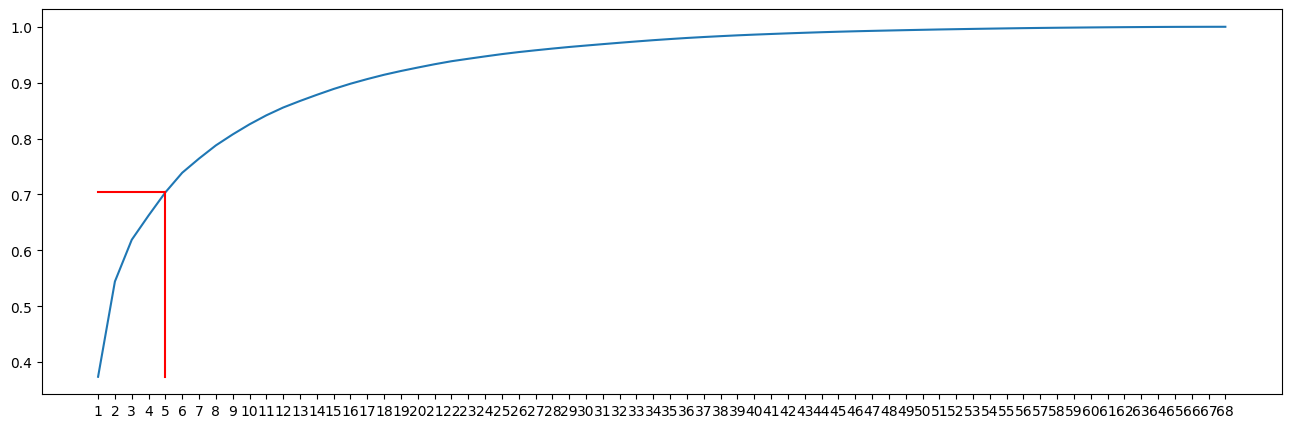

In [101]:
n_PCA = find_n_PC(pca.explained_variance_ratio_, 0.7)

### <span style ='color:orange'> n_PCA vs n_CLUST search

#### Functions

In [102]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.stats import entropy

In [ ]:
def clusters(X_proj, n_clust:int, method:str):
    if '_' in method :
        linkage = method.split('_')[1]
    clustering = KMeans(n_clusters= n_clust).fit(X_proj) if method == 'kmeans' else AgglomerativeClustering(n_clusters= n_clust, linkage= linkage).fit(X_proj)
    labels = clustering.labels_
    return labels 

## v1 - used for iterations 1 to 4
# def cluster_penalty_term(labels:np.array):
#     _, counts = np.unique(labels, return_counts= True)
#     return (np.vstack([(counts - counts.mean())/counts.mean(), np.zeros(counts.shape[0])]).min(axis = 0)**2).mean()

## v2 used for iteration 5
# def cluster_penalty_term(labels:np.array):
#     unique, counts = np.unique(labels, return_counts= True)
#     return np.abs(np.log(counts / counts.mean())).mean() / unique.shape[0]

# v3 used for iteration 6 onwards
def cluster_penalty_term(labels:np.array):
    _, counts = np.unique(labels, return_counts= True)
    return (counts / counts.sum()).std()

def entropy_weighting(labels:np.array):
    unique, counts = np.unique(labels, return_counts= True)
    freq = counts / counts.sum()
    return entropy(freq) / np.log(unique.shape[0])

def clustering_comparison(df:pd.DataFrame, scaling_methods: list, evr_targets:list, n_clusts, methods:list):
    n_exps = len(scaling_methods) * len(evr_targets) * len(n_clusts) * len(methods)
    n_exps_per_scaler = len(evr_targets) * len(n_clusts) * len(methods)
    n_exps_per_evr = len(n_clusts) * len(methods)
    n_exps_per_method = len(n_clusts)
    results = []
    best_score, best_penalized_score, best_entropy_weighted_score = 0, 0, 0
    for i, scaling_method in enumerate(scaling_methods) :
        scaler = SCALERS[scaling_method]()
        df_scaled = scaler.fit_transform(df)
        basis_pca = PCA().fit(df_scaled)
        for j, evr in enumerate(evr_targets) :
            n_PCA = find_n_PC(basis_pca.explained_variance_ratio_, evr, display_fig= False, verbose = False)
            _PCA = PCA(n_components=n_PCA)
            _PCA.fit(df_scaled)
            _X_proj = _PCA.transform(df_scaled) 
            for k, method in enumerate(methods):
                for l, n_clust in enumerate(n_clusts):
                    labels = clusters(X_proj= _X_proj, n_clust= n_clust, method=method)
                    clustering_silhouette = silhouette_score(_X_proj, labels) 
                    penalty_score = cluster_penalty_term(labels)
                    entropy_score = entropy_weighting(labels)
                    results.append({'method': method, 
                                    'scaling': scaling_method, 
                                    'evr': evr, 
                                    'n_PC': n_PCA , 
                                    'n_clust': n_clust, 
                                    'silhouette_score': clustering_silhouette,
                                    'entropy': entropy_score,
                                    'penalty_score': penalty_score})
                    counter = i * n_exps_per_scaler + j * n_exps_per_evr + k * n_exps_per_method + l
                    best_score = max(best_score, clustering_silhouette)
                    best_entropy_weighted_score = max(best_entropy_weighted_score, entropy_score * clustering_silhouette)
                    best_penalized_score = max(best_penalized_score, clustering_silhouette - penalty_score * PENALTY_RATE)
                    
                    
                    print(f"Processing experiment n° {counter+1:>4} of {n_exps} - Best Silhouette Score = {best_score:.4f}, Best Entropy-weighted Silhouette Score = {best_entropy_weighted_score:.4f}, Best Penalized Score = {best_penalized_score:.4f}", end = '\r')
    return pd.DataFrame(results)

In [104]:
def clusters_from_evr(df: pd.DataFrame, 
                      evr: float = 0.8, 
                      n_clust: int = 10, 
                      method: str = 'kmeans', 
                      scaling_method: str = 'standard',
                      feature_selection: str = 'excl'):
    
    selected_df = df[_incl] if feature_selection == 'incl' else df.drop(columns = _drop)
    if scaling_method is not None:
        scaler = SCALERS[scaling_method]()
        df_scaled = scaler.fit_transform(selected_df)
    else :
        df_scaled = selected_df
    
    basis_pca = PCA().fit(df_scaled)
    n_PCA = find_n_PC(basis_pca.explained_variance_ratio_, evr, display_fig= False, verbose = True)
    _PCA = PCA(n_components=n_PCA)
    _PCA.fit(df_scaled)
    X_proj = _PCA.transform(df_scaled) 
    labels = clusters(X_proj, n_clust, method)
    silhouette = silhouette_score(X_proj, labels)
    penalty = - cluster_penalty_term(labels) * PENALTY_RATE
    print(f"Silhouette score : {silhouette:.3f}, penalization : {penalty:.3f}")
    return X_proj, labels   

#### Operations

In [105]:
evrs = [0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 0.98]
n_clusts = range(2,15)
methods = ['kmeans',
            'agg_ward',
            'agg_average',
            'agg_complete',
            # 'agg_single'
            ]
scaling_methods = ['standard', 'robust', 'minmax']
len(scaling_methods) * len(evrs) * len(n_clusts) * len(methods)

1404

<sopan style = 'color:cyan'>Findings and comments : </span>
* `v0` and `v1` clustering distinctions are made by Centers and Power Forwards
* `v1` introduces `penalty_score`
* `v2` tries to balance player identification by reducing statistics designed for PF and C. Only for `incl` feature selection mode
* `v3` introduces auto exclusion for features
* `v4` adds positions (before scaling and PCA) 
* `v5` introduces new `penalty_score`, with positions considered




In [106]:
feature_selections = ['incl', 'excl', 'auto_excl']
_cdf_list = []
run_clustering_comparison = True
version = 6
if run_clustering_comparison :
    for fs in feature_selections:
        print(f"Running analysis for feature selection {fs}")
        selected_df = df[_incl] if fs == 'incl' else df.drop(columns = _drop if feature_selections == 'excl' else _auto_drop)
        _cdf = clustering_comparison(df = selected_df, scaling_methods= scaling_methods,  evr_targets= evrs, n_clusts= n_clusts, methods= methods)
        _cdf['feature_selection'] = fs
        _cdf_list.append(_cdf)
        print("\n")
    cdf = pd.concat(_cdf_list)
    cdf.to_csv(PREPROC_DATA_PATH / 'ARO_clustering' / f"ARO_clustering_v{version}.csv")
else :
    cdf = pd.read_csv(PREPROC_DATA_PATH / 'ARO_clustering' / f"ARO_clustering_v{version}.csv", index_col = 0)
cdf.sort_values('silhouette_score', ascending=False)[:5]

Running analysis for feature selection incl
Processing experiment n° 1404 of 1404 - Best Silhouette Score = 0.8667, Best Entropy-weighted Silhouette Score = 0.4624, Best Penalized Score = 0.4624

Running analysis for feature selection excl
Processing experiment n° 1404 of 1404 - Best Silhouette Score = 0.8765, Best Entropy-weighted Silhouette Score = 0.3833, Best Penalized Score = 0.3833

Running analysis for feature selection auto_excl
Processing experiment n° 1404 of 1404 - Best Silhouette Score = 0.8765, Best Entropy-weighted Silhouette Score = 0.3833, Best Penalized Score = 0.3833



,method,scaling,evr,n_PC,n_clust,silhouette_score,entropy,penalty_score,feature_selection
507,agg_complete,robust,0.4,2,2,0.876528,0.014623,0.49867,auto_excl
494,agg_average,robust,0.4,2,2,0.876528,0.014623,0.49867,auto_excl
494,agg_average,robust,0.4,2,2,0.876528,0.014623,0.49867,excl
507,agg_complete,robust,0.4,2,2,0.876528,0.014623,0.49867,excl
559,agg_complete,robust,0.5,2,2,0.866735,0.014623,0.49867,incl


In [107]:
cdf['penalized_silhouette_score'] = cdf['silhouette_score'] - cdf['penalty_score'] * PENALTY_RATE 
cdf['entropy_weighted_silhouette'] = cdf['silhouette_score'] * cdf['entropy']
display(cdf.sort_values('entropy_weighted_silhouette', ascending=False)[:5])
display(cdf[cdf['n_clust'] >5].sort_values('entropy_weighted_silhouette', ascending=False)[:5])

,method,scaling,evr,n_PC,n_clust,silhouette_score,entropy,penalty_score,feature_selection,penalized_silhouette_score,entropy_weighted_silhouette
936,kmeans,minmax,0.4,2,2,0.473298,0.999464,0.013630,incl,0.459668,0.473045
988,kmeans,minmax,0.5,2,2,0.473298,0.999464,0.013630,incl,0.459668,0.473045
1001,agg_ward,minmax,0.5,2,2,0.471395,0.999768,0.008976,incl,0.462419,0.471285
949,agg_ward,minmax,0.4,2,2,0.471395,0.999768,0.008976,incl,0.462419,0.471285
990,kmeans,minmax,0.5,2,4,0.468092,0.975702,0.064669,incl,0.403423,0.456718


,method,scaling,evr,n_PC,n_clust,silhouette_score,entropy,penalty_score,feature_selection,penalized_silhouette_score,entropy_weighted_silhouette
992,kmeans,minmax,0.5,2,6,0.428878,0.940598,0.071561,incl,0.357316,0.403402
940,kmeans,minmax,0.4,2,6,0.425178,0.946998,0.067733,incl,0.357446,0.402643
942,kmeans,minmax,0.4,2,8,0.410489,0.948416,0.058572,incl,0.351918,0.389315
993,kmeans,minmax,0.5,2,7,0.395927,0.949714,0.059489,incl,0.336438,0.376018
941,kmeans,minmax,0.4,2,7,0.398838,0.941930,0.063597,incl,0.335241,0.375677


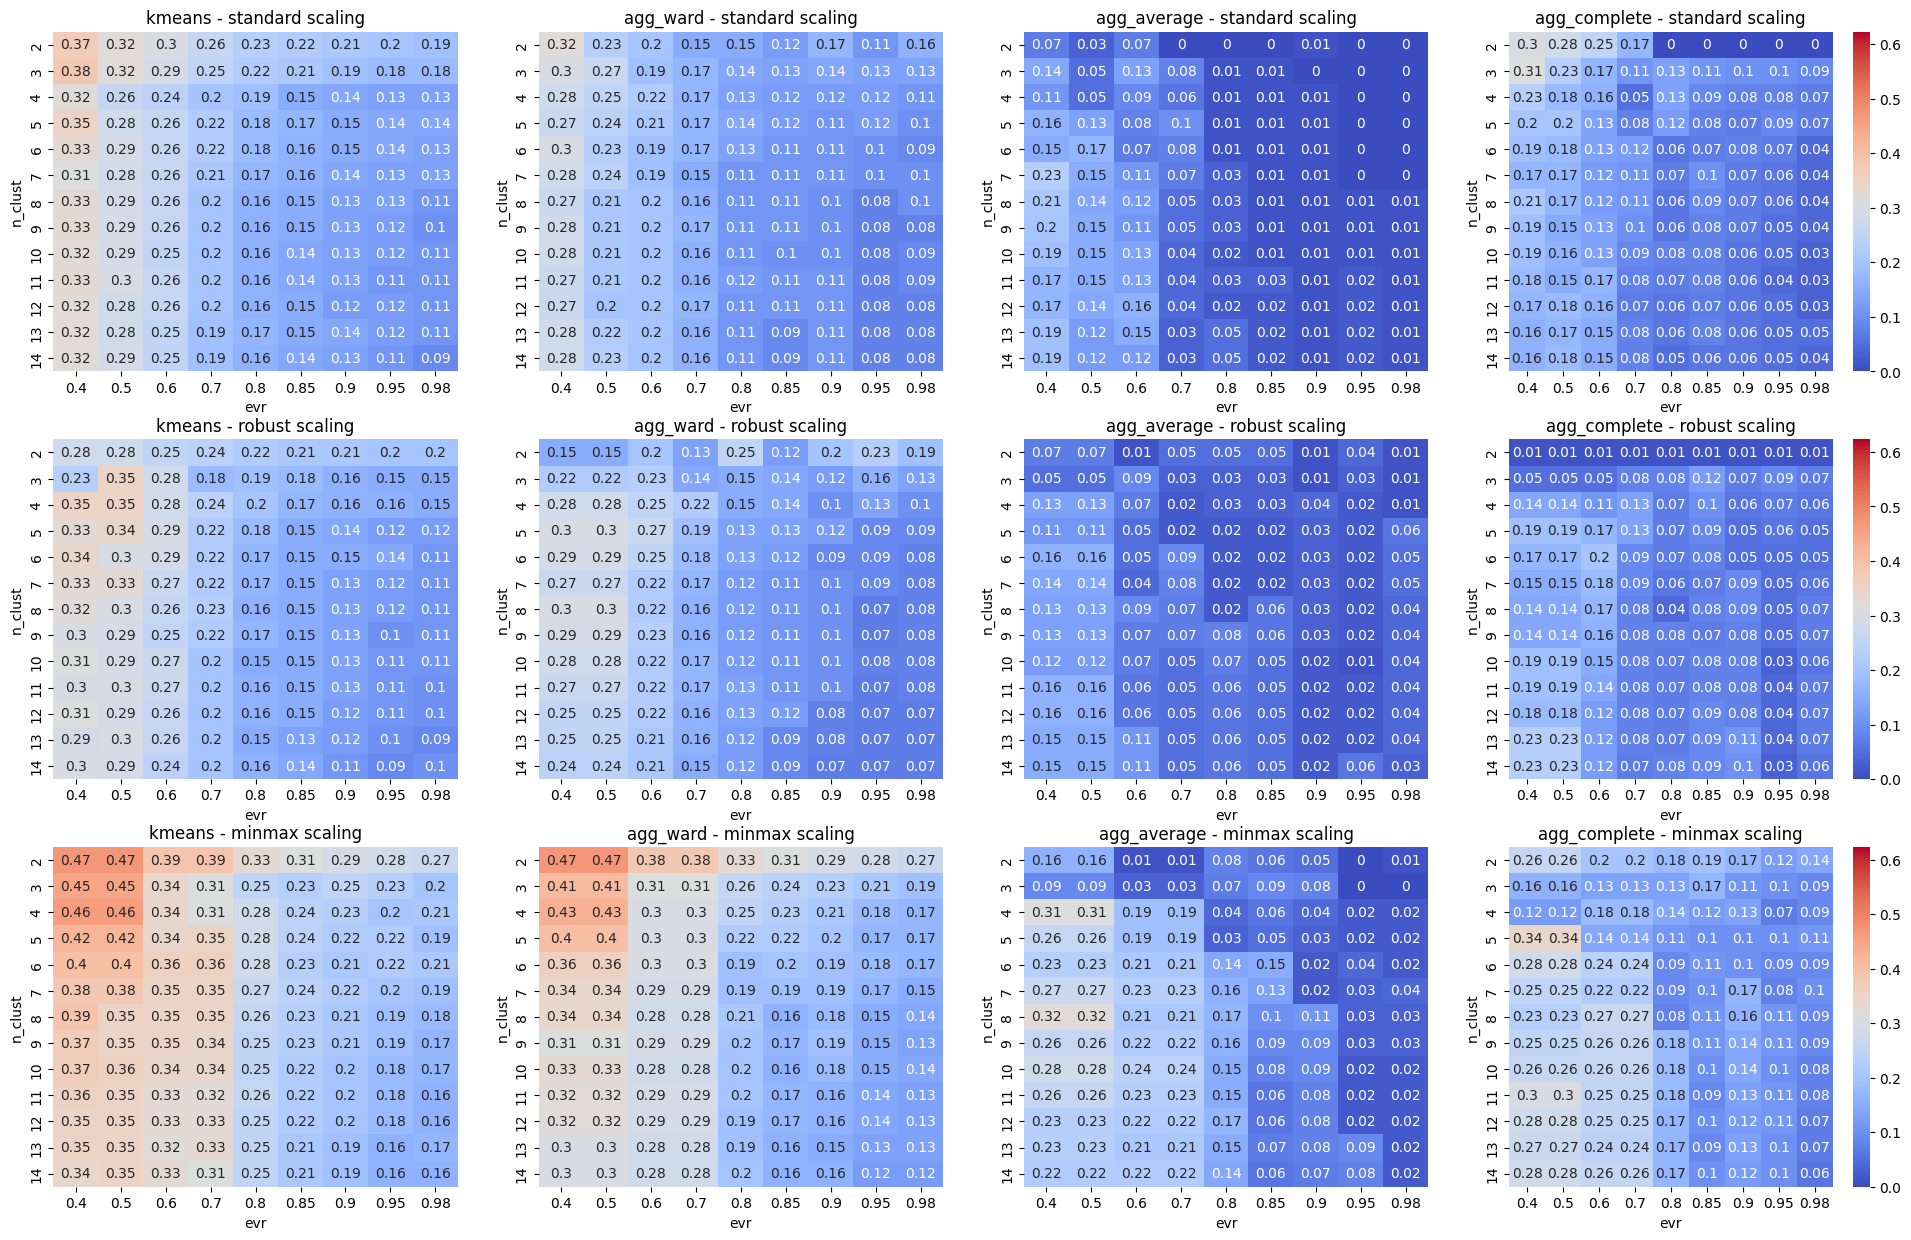

In [108]:
fs = 'incl'
metric = 'entropy_weighted_silhouette'
heatmap_kw = {'cmap': 'coolwarm', 'vmin': max(cdf[metric].min()-0.15,0), 'vmax':cdf[metric].max()+0.15, 'annot': True}
fig, axs = plt.subplots(len(scaling_methods),len(methods),figsize = (6*len(methods),5* len(scaling_methods)));
for i, ax in enumerate(axs.flatten()) :
    method = methods[i % len(methods)]
    scaling = scaling_methods[i // len(methods)]
    sns.heatmap(data= cdf[(cdf['method']==method)&(cdf['scaling']==scaling)&(cdf['feature_selection']==fs)].pivot(index = 'n_clust', columns = ['evr'], values = metric).round(2), 
                ax = ax, **heatmap_kw, cbar = (i % len(methods)) == len(methods) -1);
    ax.set_title(f"{method} - {scaling} scaling");


### penalty_score


In [53]:
evr = 0.8
n_clust = 8
scaling = 'robust'
fs = 'incl'

_, labels_ward = clusters_from_evr(df= df, evr = evr, n_clust = n_clust, method = 'agg_ward', scaling_method= scaling, feature_selection= fs)
_, labels_kmeans = clusters_from_evr(df= df, evr = evr, n_clust = n_clust, method = 'kmeans', scaling_method= scaling, feature_selection= fs)
_, labels_aggavg_plus = clusters_from_evr(df= df, evr = evr, n_clust = n_clust + 2, method = 'agg_average', scaling_method= scaling, feature_selection= fs)
_, labels_aggavg = clusters_from_evr(df= df, evr = evr, n_clust = n_clust, method = 'agg_average', scaling_method= scaling, feature_selection= fs)
_, labels_aggavg_minus = clusters_from_evr(df= df, evr = evr, n_clust = n_clust - 2, method = 'agg_average', scaling_method= scaling, feature_selection= fs)


Threshold 0.80 reached with 9 Principal Components
Silhouette score : 0.157, penalization : -0.157
Threshold 0.80 reached with 9 Principal Components
Silhouette score : 0.195, penalization : -0.117
Threshold 0.80 reached with 9 Principal Components
Silhouette score : 0.439, penalization : -0.396
Threshold 0.80 reached with 9 Principal Components
Silhouette score : 0.431, penalization : -0.549
Threshold 0.80 reached with 9 Principal Components
Silhouette score : 0.567, penalization : -0.744


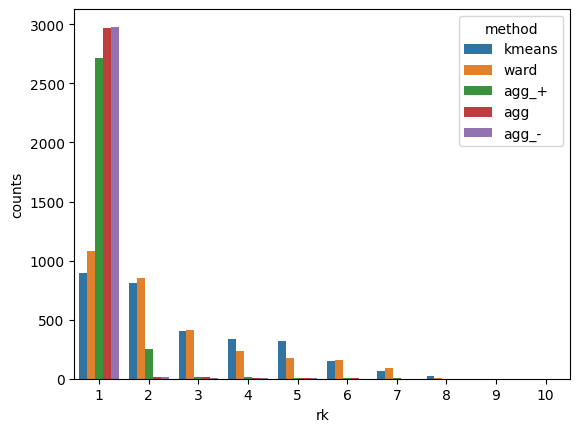

In [54]:
fig, ax = plt.subplots(1,1)
cts = []
for _labels, method in zip([labels_kmeans, labels_ward, labels_aggavg_plus, labels_aggavg, labels_aggavg_minus], ['kmeans','ward','agg_+', 'agg', 'agg_-']):
    _, counts = np.unique(_labels, return_counts= True)
    counts.sort()
    _df = pd.DataFrame(counts).rename(columns = {0:'counts'})
    _df['method'] = method
    _df['rk'] = [_df.shape[0] - x for x in _df.index]
    cts.append(_df)
_ddf = pd.concat(cts, axis = 0)
sns.barplot(data = _ddf, x = 'rk', y = 'counts', hue = 'method');


In [56]:
from scipy.stats import entropy

for _labels in [labels_kmeans, labels_ward, labels_aggavg_plus, labels_aggavg, labels_aggavg_minus]:
    _, counts = np.unique(_labels, return_counts= True)
    print(counts)
    freq = counts / counts.sum()
    print( freq.round(2) )
    n_clust = _.shape[0]
    print(f"Shannon Entropy : {entropy(freq):.3f}, Normalized : {entropy(freq) / np.log(n_clust):.3f}  | Proba std : {freq.std():.3f}")

[407 891  69 323 338 150  21 809]
[0.14 0.3  0.02 0.11 0.11 0.05 0.01 0.27]
Shannon Entropy : 1.740, Normalized : 0.837  | Proba std : 0.100
[ 411  852 1083   88  236  176    4  158]
[0.14 0.28 0.36 0.03 0.08 0.06 0.   0.05]
Shannon Entropy : 1.630, Normalized : 0.784  | Proba std : 0.121
[2718   17   11  250    4    1    2    1    3    1]
[0.9  0.01 0.   0.08 0.   0.   0.   0.   0.   0.  ]
Shannon Entropy : 0.377, Normalized : 0.164  | Proba std : 0.269
[2968   18   11    3    4    1    2    1]
[0.99 0.01 0.   0.   0.   0.   0.   0.  ]
Shannon Entropy : 0.090, Normalized : 0.043  | Proba std : 0.326
[2980   18    2    3    4    1]
[0.99 0.01 0.   0.   0.   0.  ]
Shannon Entropy : 0.063, Normalized : 0.035  | Proba std : 0.369


In [257]:
def cluster_penalty_term(labels:np.array):
    unique, counts = np.unique(labels, return_counts= True)
    return np.abs(np.log(counts / counts.mean())).mean() / unique.shape[0]

for _labels in [labels_kmeans, labels_ward, labels_aggavg]:
    print(cluster_penalty_term(_labels))

0.08788752065556807
0.1570672854127735
0.5485446500560024


### Visual inspection 2D

Threshold 0.50 reached with 2 Principal Components
Silhouette score : 0.482, penalization : -0.269


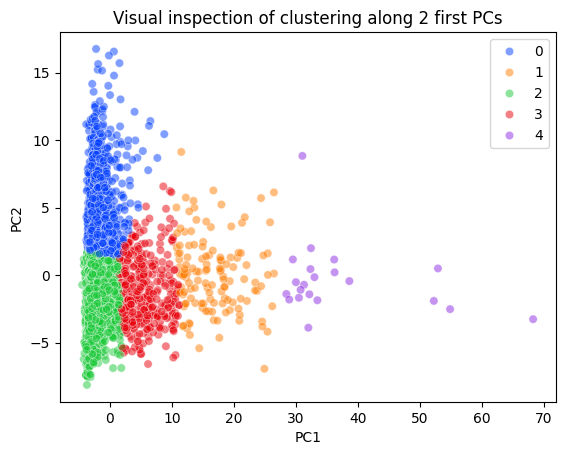

In [56]:
evr = 0.5
n_clust = 5
method = 'kmeans'
scaling = 'minmax'
feature_selection = 'incl'

X_proj, labels = clusters_from_evr(df= df, evr = evr, n_clust = n_clust, method = method, scaling_method= 'robust', feature_selection= feature_selection)
sns.scatterplot(x = X_proj[:,0], y = X_proj[:,1], hue = labels, alpha = 0.5, palette='bright');
plt.xlabel("PC1");
plt.ylabel("PC2");
plt.title("Visual inspection of clustering along 2 first PCs");


In [104]:
cluster_df = selected_df.copy()
cluster_df['id'] = [int(x.split('_')[0]) for x in cluster_df.index]
cluster_df['name'] = cluster_df['id'].map(pid2name)
cluster_df['position'] = cluster_df.index.map(pid2pos_bref)
cluster_df['season'] = [x.split('_')[1] for x in cluster_df.index]
cluster_df['cluster'] = labels
cluster_df.head(3)

,DD2,TD3,PTS_FB,PTS_PER_ELBOW_TOUCH,PTS_PER_POST_TOUCH,PTS_PER_PAINT_TOUCH,DRIVE_PTS,DRIVE_FG_PCT,CATCH_SHOOT_PTS,PULL_UP_PTS,...,OFF_BOXOUTS,DEF_BOXOUTS,PCT_BOX_OUTS_OFF,PCT_BOX_OUTS_DEF,PCT_BOX_OUTS_REB,position,id,name,season,cluster
pidSzn,,,,,,,,,,,,,,,,,,,,,
201985_2014-15,0.0,0.0,0.2,0.333,3.0,0.571,1.6,0.486,1.2,2.8,...,0.0,0.0,0.0,0.0,0.0,PG,201985,AJ Price,2014-15,2
201166_2014-15,1.0,0.0,1.1,0.464,0.0,0.303,4.9,0.465,2.6,3.5,...,0.0,0.0,0.0,0.0,0.0,PG,201166,Aaron Brooks,2014-15,2
203932_2014-15,1.0,0.0,1.1,0.643,0.4,1.157,1.2,0.449,0.9,0.3,...,0.0,0.0,0.0,0.0,0.0,PF,203932,Aaron Gordon,2014-15,2


In [105]:
cluster_df.pivot_table(index = 'cluster', columns = ['position'], values = 'id', aggfunc= 'count').fillna(0).astype(int)

position,C,PF,PG,SF,SG
cluster,,,,,
0,146,49,0,0,1
1,2,2,3,3,1
2,431,575,589,520,677
3,1,0,2,0,0
4,4,0,0,0,0
5,0,0,0,1,1


In [183]:
SMALL_CLUSTER_LIMIT = 8
small_clusters = list(cluster_df['cluster'].value_counts()[cluster_df['cluster'].value_counts()<SMALL_CLUSTER_LIMIT].index)
# cluster_df['cluster'].value_counts()

In [185]:
cluster_df[cluster_df['cluster'].isin(small_clusters)][['name','position','season','cluster']].sort_values('cluster')

,name,position,season,cluster
pidSzn,,,,
1629648_2019-20,Jordan Bone,PG,2019-20,3
201583_2019-20,Ryan Anderson,C,2019-20,3
201281_2017-18,Andre Ingram,SG,2017-18,4
1628421_2017-18,Devin Robinson,SF,2017-18,4
203954_2018-19,Joel Embiid,C,2018-19,5
200746_2017-18,LaMarcus Aldridge,C,2017-18,5
202326_2017-18,DeMarcus Cousins,C,2017-18,5
203954_2017-18,Joel Embiid,C,2017-18,5
200746_2018-19,LaMarcus Aldridge,C,2018-19,5


In [204]:
cluster_df[cluster_df['cluster']==1][['name','season','cluster']]

,name,season,cluster
pidSzn,,,
203458_2017-18,Alex Len,2017-18,1
203076_2017-18,Anthony Davis,2017-18,1
202687_2017-18,Bismack Biyombo,2017-18,1
202326_2017-18,DeMarcus Cousins,2017-18,1
202324_2017-18,Derrick Favors,2017-18,1
1627734_2017-18,Domantas Sabonis,2017-18,1
2730_2017-18,Dwight Howard,2017-18,1
202334_2017-18,Ed Davis,2017-18,1
202328_2017-18,Greg Monroe,2017-18,1
